In [1]:
import pandas as pd
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,confusion_matrix,classification_report
import pickle

# Classe Preprocessing

In [2]:
class Preprocess():
    
    # Attribut de classe
    wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new',
        'now','call','tone','claim','won','chance']
    
    # constructeur
    def __init__(self,df):
        self.df_ = df
        self.df_['text'] = self.df_['text'].apply(self.text_cleaning_encoding)
        self.df_['length'] = self.df_['text'].str.len()
        self.df_['words_count'] = self.df_['text'].apply(lambda x: len(x.split(" ")))
        self.df_['uppercases_count'] = self.df_['text'].str.findall(r'[A-Z]').str.len()
        self.df_['lowercases_count'] = self.df_['text'].str.findall(r'[a-z]').str.len()
        self.df_['number_sequence'] = self.df_['text'].map(self.isNumberSequenceInText)
        self.df_['url_or_mail'] = self.df_['text'].map(self.isUrlMailInText)
        self.df_['special_char_count'] = self.df_['text'].map(self.countSpecialCharInText)
        self.df_['words_fateful_count'] = self.df_['text'].map(self.countWordsInText)
        
        # Suppresion de la colonne text, inutile pour le ML
        self.df_.drop('text',axis=1,inplace=True)
        
        # Preparation des features et de la target pour entrainement
        # ------------------------
        # Est-ce le dataframe d'entrainement ou celui de la prediction ?
        self.y = None # Pas de target si c'est pour une prediction
        if 'target' in self.df_.columns:
            self.X = self.df_.drop(columns=['target','special_char_count','words_fateful_count'])
            
            # et encodage de la target (1 ou 0)
            self.lb_encod = LabelEncoder()
            self.y = self.lb_encod.fit_transform(self.df_['target'])
            
        else:
            self.X = self.df_.drop(columns=['special_char_count','words_fateful_count'])
        
        # Preparation des colonnes pour normalisation
        self.column_num = ['length','words_count','uppercases_count','lowercases_count']
        self.transfo_num = Pipeline(steps=[('scaling', MinMaxScaler())])
        #self.transfo_num = Pipeline(steps=[('imputer',SimpleImputer())])
        

    def text_cleaning_encoding(self,text):
        text = re.sub('&lt;#&gt;',"",text) #Removing square brackets from the text
        return(text) 
        
    def isNumberSequenceInText(self,txt):
        countNumber = len(re.findall("(\d{2})", txt))
        return countNumber
    
    def isUrlMailInText(self,txt):
        if bool(re.search("((https?:\/\/|www\.)[a-zA-Z0-9-_\.]+)|(\w+@\w+)", txt)):
            return 1
        else:
            return 0


    def countSpecialCharInText(self,txt):
        category = 0
        nbSpecialChar = len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))
        if nbSpecialChar == 1:
            category = 1
        elif nbSpecialChar > 1 and nbSpecialChar < 7:
            category = 2
        elif nbSpecialChar > 6 and nbSpecialChar < 13:
            category = 3
        elif nbSpecialChar > 12:
            category = 4

        return category

    def countWordsInText(self,txt):
        res = 0
        nb = 0
        for i in Preprocess.wordsList:
            nb += len(re.findall(r"\b" + i + r"\b", txt))

        if nb > 3:
            res = 1
        else:
            res = 0

        return res
    
    def getDf(self):
        return self.df_
    
    def getPipeline(self):
        return self.transfo_num
    
    def getFeatures(self):
        return self.X
    
    def getTarget(self):
        return self.y

# Classe ModelEvaluation

In [3]:
class ModelEvaluation():
    
    # constructeur
    def __init__(self,pipeline,model):
        self.model = model
        self.pipeline = pipeline
        self.addStepModel()
        self.fitModel()
        self.predict(X_test)
        self.showScore()
        
    def addStepModel(self):
        self.pipeline.steps.append(['model',self.model])
        print(self.pipeline)
        
    def fitModel(self):
        self.pipeline.fit(X_train, y_train)
    
    def predict(self,X_test):
        self.y_pred = self.pipeline.predict(X_test)
        
    def predict_proba(self,X_test):
        print(self.pipeline.predict_proba(X_test)) 
        
    def showScore(self):
        self.score = accuracy_score(y_test, self.y_pred)
        print(self.model,"score :", round(self.score, 5))
        
    def getTargetPred(self):
        return self.y_pred
    
    def getPipeline(self):
        return self.pipeline

In [4]:
# Dataframe SpamClassifier
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [5]:
# Nettoyage du dataframe
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)
df.drop_duplicates(inplace=True) # Suppression des doublons

In [6]:
preproc = Preprocess(df)

In [7]:
df = preproc.getDf()
X = preproc.getFeatures()
y = preproc.getTarget()
pipeline = preproc.getPipeline()

In [8]:
# Preparation pour entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=45)

In [9]:
RandomForest = ModelEvaluation(pipeline,RandomForestClassifier())

Pipeline(steps=[('scaling', MinMaxScaler()),
                ['model', RandomForestClassifier()]])
RandomForestClassifier() score : 0.98646


In [10]:
RandomForest.showScore()

RandomForestClassifier() score : 0.98646


In [11]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

'\nlb_encod = LabelEncoder()\nfrom sklearn.metrics import ConfusionMatrixDisplay\nConfusionMatrixDisplay.from_estimator(estimator = RandomForest.getPipeline(),\n                                      X = X_test,\n                                      y = y_test,\n                                      display_labels=np.unique(lb_encod.inverse_transform(RandomForest.getPipeline().classes_)))\n'

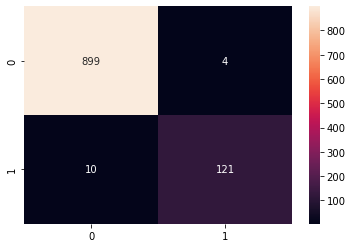

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test, RandomForest.getTargetPred())
#plt.figure(figsize=(10,6),)
#sns.heatmap(cf_matrix, annot=True)
#print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, fmt="d")
"""
lb_encod = LabelEncoder()
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(estimator = RandomForest.getPipeline(),
                                      X = X_test,
                                      y = y_test,
                                      display_labels=np.unique(lb_encod.inverse_transform(RandomForest.getPipeline().classes_)))
"""

In [13]:
def evaluation(model):
    print(confusion_matrix(y_test,RandomForest.getTargetPred()))
    print(classification_report(y_test,RandomForest.getTargetPred()))
    
evaluation(RandomForest.getPipeline())

[[899   4]
 [ 10 121]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       903
           1       0.97      0.92      0.95       131

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



In [14]:
"""
RandomForest.predict(X_new)
y_pred_new = RandomForest.getTargetPred()
if y_pred_new == 0:
    print('ham')
else:
    print('spam')
"""

"\nRandomForest.predict(X_new)\ny_pred_new = RandomForest.getTargetPred()\nif y_pred_new == 0:\n    print('ham')\nelse:\n    print('spam')\n"

In [15]:
# Creation d'un nouveau dataframe
df_predict = pd.DataFrame()
df_predict['text'] = ['XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL']#['www.sexshop.com 4654987 call dollards']
preprocess = Preprocess(df_predict)
df_new = preprocess.getDf() 
X_new = preprocess.getFeatures()

In [16]:
# Enregistrement du modele
saved_model = pickle.dump(RandomForest.getPipeline(),open('model.pkl','wb'))

In [17]:
# Test d'une conversion d'un modele en binary avant export (serialization)
saved_model = pickle.dumps(RandomForest.getPipeline())
RandomForestBinary = pickle.loads(saved_model) # Load the pickled model

In [18]:
def labelEncode(y):
    if y == 0:
        return 'ham'
    else:
        return 'spam'

In [19]:
# Prediction et recuperation de la prediction du modele de jupyter
y_pred = RandomForest.getPipeline().predict(X_new) 
#y_pred = RandomForest.getTargetPred()
print(labelEncode(y_pred))
print(RandomForest.getPipeline().predict_proba(X_new))

spam
[[0.31 0.69]]


In [20]:
# Prediction du modele binaire generé
y_binary_pred = RandomForestBinary.predict(X_new)
print(labelEncode(y_binary_pred))
print(RandomForestBinary.predict_proba(X_new))

spam
[[0.31 0.69]]


In [21]:
import joblib
modelJoblib = joblib.dump(RandomForest.getPipeline(),'model_jlib')

In [22]:
m_jlib = joblib.load('model_jlib')

In [23]:
y_joblib = m_jlib.predict(X_new)
print(labelEncode(y_joblib))
print(m_jlib.predict_proba(X_new))

spam
[[0.31 0.69]]
